In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import stft
import torchvision

In [24]:
path = 'dataset/Generate_ECG_PPG/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc_csv/bidmc_02_Signals.csv'
df = pd.read_csv(path)

In [25]:
625*2

1250

(33, 39)


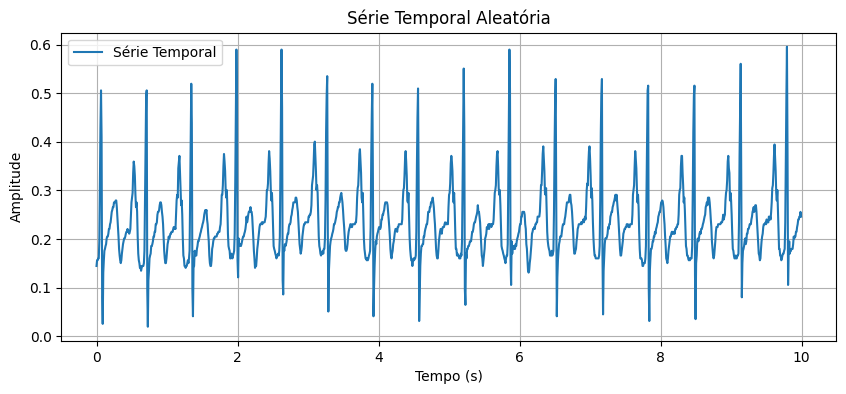

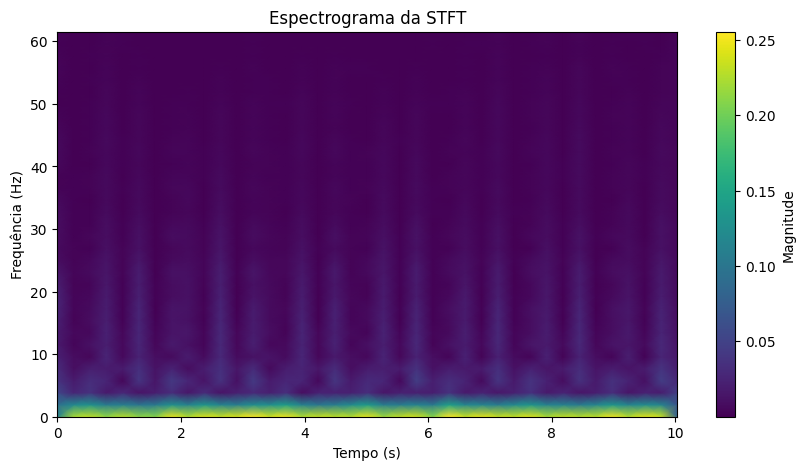

In [26]:
size_sample = 625*2
ecg = df[' II'].values[:size_sample]
t = df['Time [s]'].values[:size_sample]

T = 0.008
fs = 1/T
nperseg = 80

frequencies, times, Zxx = stft(ecg, fs, nperseg=65)

print(Zxx.shape)

plt.figure(figsize=(10, 4))
plt.plot(t, ecg, label="Série Temporal")
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")
plt.title("Série Temporal Aleatória")
plt.legend()
plt.grid()
plt.show()

# Plotar o espectrograma da STFT
plt.figure(figsize=(10, 5))
plt.pcolormesh(times, frequencies, np.abs(Zxx), shading='gouraud')
plt.colorbar(label="Magnitude")
plt.xlabel("Tempo (s)")
plt.ylabel("Frequência (Hz)")
plt.title("Espectrograma da STFT")
plt.show()


In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiStreamCNN(nn.Module):
    def __init__(self, num_classes=10):  # Ajuste num_classes conforme necessário
        super(MultiStreamCNN, self).__init__()
        
        # Stream 1: ECG Spectrogram
        self.ecg_conv = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),  # (Entrada RGB)
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # Stream 2: EMG Spectrogram
        self.emg_conv = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),  # (Entrada RGB)
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # Fully Connected Layers
        self.fc = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, ecg, emg):
        ecg_features = self.ecg_conv(ecg)
        emg_features = self.emg_conv(emg)
        
        ecg_features = torch.flatten(ecg_features, start_dim=1)
        emg_features = torch.flatten(emg_features, start_dim=1)
        
        combined_features = torch.cat((ecg_features, emg_features), dim=1)
        output = self.fc(combined_features)
        return output


In [28]:
dummy_ecg = torch.randn(1, 1, 33, 39)  # 1 imagem de espectrograma ECG
dummy_emg = torch.randn(1, 1, 33, 39)  # 1 imagem de espectrograma EMG

model = MultiStreamCNN(num_classes=10)
output = model(dummy_ecg, dummy_emg)  # Passa os dados pela rede

print(output.shape)  # Deve retornar (1, 10), que são as 10 classes

torch.Size([1, 10])


In [29]:
class BioCNN(nn.Module):
    def __init__(self, num_classes=53, in_channels = 1):  # Ajuste num_classes conforme necessário
        super(BioCNN, self).__init__()
        
        # Stream 1: ECG Spectrogram or PPG Spectrogram
        self.ecg_conv = nn.Sequential(
            nn.Conv2d(in_channels, 8, kernel_size=3, padding=1),  # (Entrada Escala de cinza)
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # Fully Connected Layers
        self.fc = nn.Sequential(
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, signal):
        signal_features = self.ecg_conv(signal)
        signal_features = torch.flatten(signal_features, start_dim=1)

        flatten_features = torch.flatten(signal_features)
        output = self.fc(flatten_features)
        return output

In [30]:
dummy_ecg = torch.randn(1, 1, 33, 39)  # 1 imagem de espectrograma ECG

model = BioCNN(num_classes=10)
output = model(dummy_ecg)  # Passa os dados pela rede

print(output.shape)  # Deve retornar (1, 10), que são as 10 classes

torch.Size([10])


In [31]:
dummy_ecg

tensor([[[[ 0.0467,  0.7716, -1.2396,  ..., -2.8351, -0.4274,  1.0828],
          [-1.2134,  0.0394,  0.5149,  ...,  0.1969,  1.9870,  0.2751],
          [-0.8249, -0.5939,  0.9823,  ..., -2.7405, -0.7059, -0.9929],
          ...,
          [-0.9289, -0.2725, -0.0160,  ...,  0.9839,  0.0207,  1.1567],
          [-2.5311,  0.6293, -0.9716,  ...,  0.7913,  1.1864,  0.9822],
          [-0.4603, -0.8687,  0.4880,  ..., -0.0470, -1.2532,  0.1159]]]])

In [32]:
ecg_ppg = torch.concat((dummy_ecg, dummy_emg), dim=1)

model = BioCNN(num_classes=10)
output = model(dummy_ecg)  # Passa os dados pela rede

print(output.shape)  # Deve retornar (1, 10), que são as 10 classes

torch.Size([10])


In [33]:
ecg_ppg = torch.concat((dummy_ecg, dummy_emg), dim=1)

model = BioCNN(num_classes=10, in_channels=2)
output = model(ecg_ppg)  # Passa os dados pela rede

print(output.shape)  # Deve retornar (1, 10), que são as 10 classes

torch.Size([10])


In [34]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, df_dataset, T = 0.008, nperseg=65):
        labels = torch.tensor(df_dataset['label'].values)
        data = df_dataset[df_dataset.columns[:-1]].values

        fs = 1/T
        # aplica short transformer fourier
        frequencies, times, Zxx = stft(data, fs, nperseg=nperseg)

        datas  = torch.tensor(Zxx)
        self.data = [(datas[i], int(labels[i])) for i in range(df_dataset.shape[0])]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [35]:
frequencies, times, Zxx = stft(ecg, fs, nperseg=65)
Zxx = np.expand_dims(Zxx, axis=-1)
torch.tensor(Zxx).shape

torch.Size([33, 39, 1])

In [36]:
path_ecg = 'dataset/Generate_ECG_PPG/data/ECG_test.csv'
df_ecg = pd.read_csv(path_ecg)
labels = df_ecg['label'].astype(int).values


In [37]:
data = df[:-1].values
data.shape

(60000, 6)

In [38]:
frequencies, times, Zxx = stft(data, fs, nperseg=65)

/home/renan/.local/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 65 is greater than input length  = 6, using nperseg = 6
  warnings.warn('nperseg = {0:d} is greater than input length '


In [39]:
Zxx.shape

(60000, 4, 3)

In [ ]:
torch.LongTensor

In [123]:
class CustomDataset(Dataset):
    def __init__(self, df_dataset, T = 0.008, nperseg=65):
        data = df_dataset[df_dataset.columns[:-1]].values

        fs = 1/T
        # aplica short-time fourier transform
        frequencies, times, Zxx = stft(data, fs, nperseg=nperseg)
        
        self.data = torch.abs(torch.tensor(Zxx))  # Magnitude (escala de cinza)
        self.data = self.data.unsqueeze(1)
        self.labels = torch.tensor(df_dataset['label'].values, dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [128]:
data_set = CustomDataset(df_ecg)

In [101]:
data_set.data.shape

torch.Size([2036, 1, 33, 39])

In [129]:
trainloader = torch.utils.data.DataLoader(
        data_set, batch_size=len(data_set.data), shuffle=False)

In [112]:
for t in trainloader:
    print(t[0].shape)
    break

torch.Size([2036, 33, 39])


In [132]:
# Definindo a transformação para converter imagens em tensores
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# Carregando o dataset MNIST e aplicando a transformação
trainset = torchvision.datasets.MNIST(root='mnist', train=False, download=True, transform=transform)

trainloader2 = torch.utils.data.DataLoader(
        trainset, batch_size=len(trainset.data), shuffle=False)

for t in trainloader2:
    print(t[0].shape)
    break

torch.Size([10000, 1, 28, 28])


In [108]:
trainset.data.shape

torch.Size([10000, 28, 28])

In [117]:
data_set.data.shape

torch.Size([2036, 33, 39])

In [94]:
data_set.data.shape

torch.Size([2036, 33, 39])

In [83]:
trainloader2

In [126]:
trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=len(trainset.data), shuffle=False)

In [50]:
trainset.data.shape

torch.Size([10000, 28, 28])

In [69]:
torch.utils.data.DataLoader(
        trainset, batch_size=len(trainset.data), shuffle=False)

In [74]:
for x in trainloader:
    print(x[0].shape)
    break

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>

In [133]:

for _, train_data in enumerate(trainloader2, 0):
    trainset.data, trainset.targets = train_data

dataset_image = []
dataset_label = []

dataset_image.extend(trainset.data.cpu().detach().numpy())
dataset_label.extend(trainset.targets.cpu().detach().numpy())
dataset_image = np.array(dataset_image)
dataset_label = np.array(dataset_label)

In [134]:
dataset_image.shape

(10000, 1, 28, 28)

In [131]:
dataset_image.shape

(2036, 1, 33, 39)

In [139]:
path = 'dataset/Generate_ECG_PPG/data/ECG_PPG_train.csv'
df = pd.read_csv(path)

In [140]:
df_selected = df.applymap(lambda x: x[0] if isinstance(x, list) else x)

/tmp/ipykernel_9777/897102002.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_selected = df.applymap(lambda x: x[0] if isinstance(x, list) else x)


In [141]:
df_selected

,0,1,2,3,4,5,6,7,8,9,...,1241,1242,1243,1244,1245,1246,1247,1248,1249,label
0,"[0.43597, -0.025391]","[0.435, -0.0097656]","[0.43304, -0.025391]","[0.43109, -0.025391]","[0.42913, -0.025391]","[0.42717, -0.019531]","[0.4262, -0.025391]","[0.42424, -0.013672]","[0.42326, -0.025391]","[0.42131, -0.025391]",...,"[0.6002, 0.03125]","[0.59433, 0.0058594]","[0.58847, -0.039062]","[0.58162, -0.054688]","[0.57478, -0.064453]","[0.56794, -0.070312]","[0.56207, -0.054688]","[0.55718, -0.035156]","[0.5523, 0.041016]",41
1,"[0.35484, 0.44531]","[0.35386, 0.43945]","[0.35288, 0.44922]","[0.35093, 0.44922]","[0.34897, 0.45508]","[0.34702, 0.46094]","[0.34604, 0.45508]","[0.34311, 0.46094]","[0.34115, 0.47461]","[0.3392, 0.4707]",...,"[0.31378, 0.44922]","[0.30987, 0.43945]","[0.30596, 0.43945]","[0.30205, 0.43555]","[0.29814, 0.42969]","[0.29423, 0.42578]","[0.2913, 0.41992]","[0.28837, 0.41992]","[0.28641, 0.42578]",29
2,"[0.55914, 0.79492]","[0.55718, 0.82422]","[0.55425, 0.62891]","[0.5523, 0.45508]","[0.54936, 0.2793]","[0.54643, 0.16992]","[0.54448, 0.13086]","[0.54252, 0.16992]","[0.54057, 0.21484]","[0.53861, 0.16602]",...,"[0.53079, 0.74414]","[0.52884, 0.58008]","[0.5259, 0.43555]","[0.52297, 0.28516]","[0.52004, 0.21484]","[0.51711, 0.16016]","[0.51417, 0.17969]","[0.51124, 0.18555]","[0.51026, 0.15625]",19
3,"[0.35484, 0.7793]","[0.37537, 0.77539]","[0.40176, 0.75]","[0.43304, 0.72461]","[0.46921, 0.70508]","[0.50831, 0.69922]","[0.54741, 0.69531]","[0.57967, 0.69922]","[0.60508, 0.69922]","[0.62952, 0.69531]",...,"[0.46041, 0.72461]","[0.47801, 0.72461]","[0.49756, 0.7207]","[0.51808, 0.71484]","[0.53763, 0.7207]","[0.55327, 0.70898]","[0.56598, 0.70508]","[0.5738, 0.70898]","[0.57674, 0.70508]",18
4,"[1.1994, 0.1349]","[1.1896, 0.10948]","[1.1769, 0.064516]","[1.1662, 0.039589]","[1.1564, 0.01955]","[1.1417, 0.014663]","[1.1241, 0.014663]","[1.1056, 0.024438]","[1.086, 0.01955]","[1.0694, -0.00048876]",...,"[1.2952, 0.024438]","[1.2805, 0.01955]","[1.2688, 0.034702]","[1.263, 0.0097752]","[1.2688, -0.020528]","[1.2933, 0.044477]","[1.3421, 0.32502]","[1.4194, 0.90518]","[1.5259, 1.3558]",52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,"[0.32551, 0.26562]","[0.31574, 0.2793]","[0.30792, 0.2793]","[0.30303, 0.31445]","[0.3001, 0.30469]","[0.29814, 0.34961]","[0.29717, 0.30469]","[0.29619, 0.33984]","[0.29619, 0.3457]","[0.29619, 0.33594]",...,"[0.63734, 0.21094]","[0.61877, 0.24609]","[0.60117, 0.26562]","[0.58358, 0.23438]","[0.56794, 0.26562]","[0.55425, 0.26562]","[0.54057, 0.30078]","[0.52981, 0.32422]","[0.52004, 0.3457]",35
504,"[0.56305, 0.36471]","[0.54839, 0.37451]","[0.53568, 0.39412]","[0.52395, 0.4]","[0.51124, 0.4]","[0.49951, 0.4]","[0.4868, 0.3902]","[0.4741, 0.37451]","[0.46139, 0.35882]","[0.44868, 0.3549]",...,"[0.26882, 0.4902]","[0.26588, 0.50588]","[0.26393, 0.51569]","[0.261, 0.52549]","[0.25904, 0.52941]","[0.25709, 0.51569]","[0.25611, 0.50588]","[0.25415, 0.48431]","[0.25415, 0.46471]",23
505,"[0.45161, 0.62524]","[0.4477, 0.62524]","[0.44379, 0.62524]","[0.43988, 0.62524]","[0.435, 0.62524]","[0.43109, 0.63014]","[0.42717, 0.63014]","[0.42326, 0.62524]","[0.42033, 0.62524]","[0.41642, 0.62524]",...,"[0.60606, 0.33953]","[0.6129, 0.40509]","[0.61779, 0.50978]","[0.62072, 0.58023]","[0.6217, 0.6047]","[0.61975, 0.61546]","[0.61584, 0.62524]","[0.60997, 0.63503]","[0.60117, 0.63992]",24
506,"[0.40567, 0.8]","[0.39589, 0.81176]","[0.38514, 0.81569]","[0.37537, 0.83137]","[0.36559, 0.83529]","[0.35679, 0.8451]","[0.34897, 0.86667]","[0.34409, 0.88039]","[0.34018, 0.89608]","[0.33822, 0.91176]",...,"[0.0, 1.0667]","[0.0, 1.0118]","[0.064516, 0.91176]","[0.16227, 0.99216]","[0.21212, 1.0412]","[0.23656, 1.0059]","[0.24829, 0.98627]","[0.2522, 0.94706]","[0.2522, 1.2824]",27


In [157]:
torch.tensor(df.values)

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.